# Predicting bike-share program usage from weather conditions
by Elaine Chu, Dhruv Garg, Shawn Xiao Hu, Lukman Lateef, Eugene You

In [1]:
import pandas as pd
import numpy as np
# Used for preprocesing and modelling
import pandera as pa
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import deepchecks
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation
from deepchecks.tabular import Dataset
import os
import pandas as pd
import requests
import zipfile
import io
from scipy.stats import skew

# Used for plotting
import altair as alt
import altair_ally as aly  # Make sure to run `conda install pip` and `pip install altair-ally` into environment before running
#pip install deepchecks
from sklearn.metrics import PredictionErrorDisplay
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

# Summary

In this analysis, we developed two regression model using the decision tree algorithm and the ridge regression algorithm to compare their ability to predict the number of bikes being rented out from a bike share program based on the weather conditions of the hour and general information about the day. After training the model, the model's performances were evaluated on an unseen data set, where the decision tree algorithm achieved a $R^2$ of 0.79 and the ridge regression algorithm obtained a $R^2$ of 0.68. The results indicates that the regression model was able to better capture the key factors influencing the number of bike rented within a reasonable range of accuracy. This makes it a practical tool for forecasting bike demand. By utilizing weather conditions and temporal features, this model can assist bike-sharing programs in optimizing resource allocation, ensuring bikes are available when needed, and improving overall service efficiency. 

# Introduction

Over the past 2 decades, a growing number of countries worldwide have introduced bike-sharing programs as an integral part of their urban transportation systems (Shaheen et al. 2013). These initiatives are often designed to address the “last mile” problem – a common challenge in public transit to get passengers from a transportation hub, like train stations and bus stops, to their final destination. By providing a sustainable, accessible, and cost-effective mode of transportation for short trips, bike-share programs have become a popular solution to close this gap (Shaheen et al. 2013).  

The demand and usage of bike-share programs are known to be heavily influenced by the weather conditions (Eren and Uz 2020). Factors such as temperature, precipitation, humidity, and wind speed all have an affect the number of bikes being used at any given time. Understanding these relationships is crucial for the effective management of bike-share systems.

In this study, we explore whether a machine learning algorithm can predict the usage of bike-share program. It is important to accurately predict usage of the bikes as it gives organizers the ability to plan ahead and make sure there is a stable supply of bikes to match the fluctuating demands. This ensures an efficient allocation of resources and ultimately improve the overall performance of the bike-share programs.

# Methods

## Data

The data set used in this project is the Seoul bike sharing demand data set created by Dr Sathishkumar V.E., Dr Jangwoo Park, and Dr Yongyun Cho from Sunchon National University (Sathishkumar et al 2020a, 2020b). It was sourced from the UCI Machine Learning Repository (Sathishkumar et al 2020a, 2020b) and can be found [here](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand). Each row in the data set represents the number of bikes being rented at a specific hour of a day, along with corresponding weather conditions (e.g. temperature, humidity, and rainfall), whether the day was a holiday, and if the bike share program was functioning that day.

## Analysis

We developed compared two regression model that predicts the number of bikes being rented out for a specific hour of the day one is built using the decision tree regressor algorithm another using the ridge regression algorithm. All variables, except for `dew point temp`, from the original data set was used to fit the model. The data was split into training and test set at a 70:30 ratio. The `Date` column from the original data set was split up into temporal features of `Year`, `Month`, `Day`, and `Weekday`. These features along with  `Hour` and `Seasons` will be treated as categorical features and will be encoded by One-hot encoding before fitting to the model. In addtion, features that indicated events (`Holiday`, `Functioning Day`) were transformed and treated so they can be treated as binary categorical features. All the other numeric features that were related to the weather will be scaled using standardization just before model fitting. For the decision regressor algorithm the hyperparameters `tree depth`, `minimum samples per split`, and `minimum sample per leaf` were optimized based on the $R^2$ score through a 5-fold cross-validation. For the ridge regression algorithm, the hyperparameter

The Python programming language (Van Rossum and Drake 2009) and the following Python packages were used to perform the analysis: numpy (Harris et al. 2020), Pandas (McKinney 2010), altair (VanderPlas, 2018), vegafusion(Kruchten et al. 2022), scikit-learn (Pedregrosa et al. 2011). The code used to perform the analysis and create this report can be found here: https://github.com/UBC-MDS/DSCI522-2425-28-five_guys 

# Results

To identify which features may be useful to predict the number of bikes being used, we began with some exploratory exploratory data analysis (EDA) to better understand the data set's general structure and characteristics. We found that there were no missing values in the dataset, eliminating the need for any imputation or data cleaning related to missing data. The descriptions from the EDA shows the dataset includes both numerical and categorical variables (e.g., “Seasons,” “Holiday”), some of which may interact non-linearly with the target variable. 

When plotting bike usage against features such as the hour of the day, seasonality, temperature, and holiday status, we noticed non-uniform patterns in their distribution with some categories have little overlap between each other. We observed that there is a spike in the number of bikes rented in summer seasons and also there is a spike in the morning and evening of each day observed. This suggests that these features might serve as strong predictors on bike usage. 

We also plotted a correlation matrix between all the features, we found a strong correlation between temperature and dew point temperature. Given that dew point temperature values closely mirror those of temperature, we decided to drop dew point temperature from the model. The remaining features showed relatively weaker correlations, so we chose not to remove them as they may offer valueable information for predicting bike demand.

# 1.1 Data Loading

In [2]:
df = pd.read_csv(
    'https://archive.ics.uci.edu/static/public/560/seoul+bike+sharing+demand.zip', encoding='latin-1')


df.to_csv("data/SeoulBikeData.csv", index=False)  # Save it locally


df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# 1.2 Data Validation

## 1.2.1   data validation 1-2

In [3]:
# data validation 1-2
#1. check format of the data to see if it is a csv file or not

url = 'https://archive.ics.uci.edu/static/public/560/seoul+bike+sharing+demand.zip'
def check_csv_in_zip(url):
    try:
        # Stream the zip file content
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Load zip file into memory and list its contents
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            file_list = z.namelist()  # Get all file names in the zip
            csv_files = [f for f in file_list if f.endswith(".csv")]
            
            # Check if any CSV files exist
            if csv_files:
                print(f"✅ Found CSV file(s): {csv_files}")
                return True
            else:
                raise ValueError("❌ No CSV files found in the zip.")
    except zipfile.BadZipFile:
        raise ValueError("❌ The file is not a valid zip archive.")
    except requests.exceptions.RequestException as e:
        raise ValueError(f"❌ Error fetching the zip file: {e}")

# Call the function to check for CSV
try:
    check_csv_in_zip(url)
except ValueError as e:
    raise ValueError(f"❌ error with wrong file format or wrong links ")
    print(e)


# 2. data validation 2 check correct columns
required_columns = [
    'Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
    'Holiday', 'Functioning Day'
]

# Check if all required columns are present in the DataFrame
missing_columns = [col for col in required_columns if col not in df.columns]

if not missing_columns:
    print("✅ All required columns are present in the DataFrame.")
else:
    raise ValueError(f"❌ The following columns are missing from the DataFrame: {missing_columns}")

✅ Found CSV file(s): ['SeoulBikeData.csv']
✅ All required columns are present in the DataFrame.


## 1.2.2 data validation 3-8

In [4]:
# Data validation code 
import pandera as pa

schema = pa.DataFrameSchema(
    {
        "Date": pa.Column(str),
        "Rented Bike Count": pa.Column(int, pa.Check.between(0, np.inf)),
        "Hour": pa.Column(int, pa.Check.between(0, 23)),
        "Temperature(°C)": pa.Column(float),
        "Humidity(%)": pa.Column(int, pa.Check.between(0, 100)),
        "Wind speed (m/s)": pa.Column(float),
        "Visibility (10m)": pa.Column(int),
        "Dew point temperature(°C)": pa.Column(float),
        "Solar Radiation (MJ/m2)": pa.Column(float),
        "Rainfall(mm)": pa.Column(float,
                                  pa.Check(lambda s: s.isna().mean() <= 0.05,
                                           element_wise=False,
                                           error="Too many null values in 'Rainfall(mm)' column."),
                                  nullable=True),
        "Snowfall (cm)": pa.Column(float),
        "Seasons": pa.Column(str, pa.Check.isin(["Winter", "Summer", "Autumn", "Spring"])),
        "Holiday": pa.Column(str, pa.Check.isin(["Holiday", "No Holiday"])),
        "Functioning Day": pa.Column(str, pa.Check.isin(["Yes", "No"]))
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(),
                 error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(),
                 error="Empty rows found.")
    ]
)
# data validation check 3 - 8
df = schema.validate(df, lazy=True).drop_duplicates().dropna(how="all")

## Data validation check 9 - 11

In [5]:
# 9 check numerical target variable to see if it is skewed or not 
target_column = "Rented Bike Count"  # Replace with the name of your target column
# Check if the column exists in the DataFrame
if target_column in df.columns:
    # Check if the target column is numerical
    if pd.api.types.is_numeric_dtype(df[target_column]):
        # Calculate skewness
        skewness_value = skew(df[target_column].dropna())  # Drop NaN values to avoid issues
        print(f"Skewness of '{target_column}': {skewness_value:.2f}")

        # Raise an error if the data is not skewed
        if -1 <= skewness_value <= 1:
            raise ValueError(f"❌ The target variable '{target_column}' is not skewed (approximately symmetrical).")
        else:
            print(f"✅ The target variable '{target_column}' is skewed (Skewness: {skewness_value:.2f}).")
    else:
        raise ValueError(f"❌ The target variable '{target_column}' is not numerical.")
else:
    raise ValueError(f"❌ Column '{target_column}' does not exist in the DataFrame.")


Skewness of 'Rented Bike Count': 1.15
✅ The target variable 'Rented Bike Count' is skewed (Skewness: 1.15).


In [6]:
# data validation check 10 -11 


# 10. No anomalous correlations between target/response variable and features/explanatory variables
# Create a Deepchecks Dataset
deep_check = Dataset(df, label="Rented Bike Count", cat_features=[])

check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=deep_check)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")
else:
    print("✅ No anomalous correlations between target/response variable and features.")

# 11. No anomalous correlations between features/explanatory variables check 

check_feat_feat_corr = FeatureFeatureCorrelation()
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=deep_check)

# Inspect results
if not check_feat_feat_corr_result.passed_conditions():
    print("⚠️ Feature-Feature correlation issues detected.")
    raise ValueError("Feature-Feature correlation issues detected")
else:
    print("✅ No anomalous correlations between features.")

# Optionally visualize the correlation matrix
check_feat_feat_corr_result.show()


✅ No anomalous correlations between target/response variable and features.


/Users/dhruvgarg/miniforge3/envs/rental-bike-prediction/lib/python3.11/site-packages/deepchecks/ppscore.py:233: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/dhruvgarg/miniforge3/envs/rental-bike-prediction/lib/python3.11/site-packages/deepchecks/ppscore.py:233: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/dhruvgarg/miniforge3/envs/rental-bike-prediction/lib/python3.11/site-packages/deepchecks/ppscore.py:233: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/dhruvgarg/miniforge3/envs/rental-bike-prediction/lib/python3.11/site-packages/deepchecks/ppscore.py:233: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

✅ No anomalous correlations between features.


Table 1. First few rows of the Seoul bike share demand data set.

# 1.3. EDA Analysis

In [7]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values_table = pd.DataFrame({"Missing Values": missing_values})
missing_values_table

,Missing Values
Date,0
Rented Bike Count,0
Hour,0
Temperature(°C),0
Humidity(%),0
Wind speed (m/s),0
Visibility (10m),0
Dew point temperature(°C),0
Solar Radiation (MJ/m2),0
Rainfall(mm),0


Table 2. Number of missing values in every column

In [8]:
# Summary statistics
summary_stats = df.describe()
summary_stats_table = summary_stats.loc['mean':'max']
summary_stats_table

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


Table 3. Summary statistics of each column 

In [9]:
rented_bike_hist = alt.Chart(df).mark_bar().encode(
    alt.X('Rented Bike Count:Q', bin=True, title='Rented Bike Count'),
    alt.Y('count()', title='Frequency'),
    tooltip=['count()']
).properties(
    title='Distribution of Rented Bike Count',
    width=700,
    height=400
)
rented_bike_hist

alt.Chart(...)

Figure 1. Distribution of Rented Bike Count

In [10]:
hourly_avg_chart = alt.Chart(df).mark_line(point=True).encode(
    x=alt.X('Hour:O', title='Hour of Day'),
    y=alt.Y('mean(Rented Bike Count):Q', title='Average Rented Bike Count'),
    tooltip=['Hour', 'mean(Rented Bike Count)']
).properties(
    title='Average Rented Bike Count by Hour',
    width=700,
    height=400
)
hourly_avg_chart

alt.Chart(...)

Figure 2. Average Rented Bike Count by Hour

In [11]:

season_avg_chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Seasons:O', title='Season'),
    y=alt.Y('mean(Rented Bike Count):Q', title='Average Rented Bike Count'),
    color='Seasons',
    tooltip=['Seasons', 'mean(Rented Bike Count)']
).properties(
    title='Average Rented Bike Count by Season',
    width=700,
    height=400
)
season_avg_chart

alt.Chart(...)

Figure 3. Average Rented Bike Count by Season

In [12]:
alt.Chart(df).mark_circle().encode(
    alt.X('Temperature(°C):Q', title='Temperature (°C)'),
    alt.Y('Rented Bike Count:Q', title='Rented Bike Count'),
    color='Seasons:N',
    tooltip=['Temperature(°C)', 'Rented Bike Count', 'Seasons']
).properties(
    title='Number of bike rentals at different temperatures for different seasons',
    width=600,
    height=400
)

alt.Chart(...)

Figure 4. Number of bike rentals at different temperatures for different seasons 

In [13]:
alt.Chart(df).mark_boxplot().encode(
    alt.X('Holiday:N', title='Holiday'),
    alt.Y('Rented Bike Count:Q', title='Rented Bike Count'),
    color='Holiday:N',
    tooltip=['Holiday', 'Rented Bike Count']
).properties(
    title='Summary distribution of bike rentals between holidays and non holidays',
    width=600,
    height=400
)

alt.Chart(...)

Figure 5. Summary distribution of bike rentals between holidays and non holidays.

# 2. Data Preprocessing 

In [14]:
# Renaming the colums for the simplicity
df = df.rename(columns={
    'Temperature(°C)': 'Temperature',
    'Humidity(%)': 'Humidity',
    'Rainfall(mm)': 'Rainfall',
    'Snowfall (cm)': 'Snowfall',
    'Wind speed (m/s)': 'Wind speed',
    'Visibility (10m)': 'Visibility',
    'Solar Radiation (MJ/m2)': 'Radiation',
    'Dew point temperature(°C)': 'Dew point temperature'})

In [15]:
# Convert the Date column in Datetime Dtype
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

# Extract features from the Date column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df = df.drop(['Date'], axis=1)  # Exclude unwanted columns

# Convert to categorical
# df['Hour'] = df['Hour'].astype(str)
df['Seasons'] = df['Seasons'].astype(str)

# Converting to binary for EDA and for values to feed into model
df['Holiday'] = df['Holiday'].apply(lambda x: 1 if x == "Holiday" else 0)
df['Functioning Day'] = df['Functioning Day'].apply(
    lambda x: 1 if x == "Yes" else 0)

In [16]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Year,Month,Day,Weekday
3850,0,10,17.3,52,2.3,1235,7.3,2.38,0.0,0.0,Spring,0,0,2018,10,5,4
4491,562,3,19.6,68,1.7,1260,13.5,0.00,0.0,0.0,Summer,1,1,2018,6,6,2
3305,1632,17,18.3,29,4.3,1626,0.0,1.61,0.0,0.0,Spring,0,1,2018,4,17,1
2511,329,15,11.6,97,3.4,117,11.1,0.26,0.0,0.0,Spring,0,1,2018,3,15,3
2487,1025,15,21.7,39,3.3,1979,7.1,2.09,0.0,0.0,Spring,0,1,2018,3,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,0,14,24.3,39,1.7,2000,9.4,2.18,0.0,0.0,Autumn,0,0,2018,4,10,1
7763,1175,11,16.2,39,1.6,1580,2.2,2.05,0.0,0.0,Autumn,0,1,2018,10,20,5
5218,998,10,23.7,59,1.7,2000,15.2,0.89,0.0,0.0,Summer,0,1,2018,6,7,3
1346,54,2,-15.6,33,2.2,2000,-28.2,0.00,0.0,0.5,Winter,0,1,2018,1,26,4


Table 4. Overview of the training data set.

In [17]:
# Temp - rental bike graph
alt.Chart(train_df[train_df['Rented Bike Count'] != 0]).mark_bar().encode(
    x=alt.X('Rented Bike Count', bin=alt.Bin(maxbins=30)),
    y=alt.Y('count()', title='Distribution of rental bikes'),
    tooltip=['Rented Bike Count', 'count()']
)

alt.Chart(...)

Figure 6. Distribution of number of rented bikes.

In [18]:
# Hourly bike graph for seasons
alt.Chart(train_df).mark_line().encode(
    x='Hour',
    y='mean(Rented Bike Count)',
    color='Seasons',
    tooltip=['Hour', 'mean(Rented Bike Count)']
)

alt.Chart(...)

Figure 7. Mean number of bikes being rented at different time of the day.

In [19]:
# Correlation graph
# aly.corr(train_df)  # Uncomment if you installed altair-ally

Figure 8. Correlation plots for the different features in the training data set.

# 3. Modeling

In [20]:
# Model separation
X_train, y_train = train_df.drop(
    "Rented Bike Count", axis=1), train_df["Rented Bike Count"]
X_test, y_test = test_df.drop(
    "Rented Bike Count", axis=1), test_df["Rented Bike Count"]

In [21]:
# Define column transformer for preprocessing
column_transformer = make_column_transformer(
    # One-hot encode Hour, Seasons, Year, Month and Day
    (OneHotEncoder(), ['Hour', 'Seasons', 'Year', 'Month', 'Day']),
    ("drop", ['Dew point temperature']),
    remainder='passthrough'  # Leave other columns as they are
)

We implemented two regression model with a decision tree regressor algorithm and a ridge regression algorithm. To optimize the model performance in predicting bike usage, we performed a randomized 5-fold cross validation using the $R^2$ as the performance metric to evaluate and select the best value for hyperparameters. For the decision tree regressor algorithm, we specifically tuned the maximum depth of the tree, the minimum number of samples required to split a node, and the minimum samples required per leaf. For the ridge regression algorithm, the alpha value was tuned during the cross validation. Based on the analysis, we found that the optimal decision tree regressor model configuration had a maximum depth of 20, a minimum of 10 sample to split a node, and a minimum 4 samples per leaf. Whereas for the ridge regression algorithm, the optimal alpha value was 10.

In [22]:
# Ridge Regression Pipeline
ridge_pipeline = make_pipeline(
    column_transformer,
    StandardScaler(with_mean=False),
    Ridge()
)

# Decision Tree Pipeline
tree_pipeline = make_pipeline(
    column_transformer,
    StandardScaler(with_mean=False),
    DecisionTreeRegressor(random_state=42)
)


# Define parameter grids for RandomizedSearchCV
ridge_param_grid = {
    'ridge__alpha': np.logspace(-3, 3, 10)
}

tree_param_grid = {
    'decisiontreeregressor__max_depth': [None, 10, 20, 30, 40],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 4]
}

# Apply RandomizedSearchCV
ridge_search = RandomizedSearchCV(
    ridge_pipeline, ridge_param_grid, cv=5, n_iter=10, random_state=42)
tree_search = RandomizedSearchCV(
    tree_pipeline, tree_param_grid, cv=5, n_iter=10, random_state=42)

# Fit models
ridge_search.fit(X_train, y_train)
tree_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['Hour',
                                                                                'Seasons',
                                                                                'Year',
                                                                                'Month',
                                                                                'Day']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['Dew '
                                                                                'point '
                                                                                'temperature'])])),
                                             ('standardscaler',
                                              StandardScaler(with_mean=False)),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=42))]),
                   param_distributions={'decisiontreeregressor__max_depth': [None,
                                                                             10,
                                                                             20,
                                                                             30,
                                                                             40],
                                        'decisiontreeregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4],
                                        'decisiontreeregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10]},
                   random_state=42)

In [23]:
# Best tree params
tree_results = pd.DataFrame(tree_search.cv_results_)
tree_results = tree_results[tree_results["rank_test_score"] == 1].reset_index()[[
    "param_decisiontreeregressor__min_samples_split",
    "param_decisiontreeregressor__min_samples_leaf",
    "param_decisiontreeregressor__max_depth"]]
tree_results.columns = ["min_samples_split", "min_samples_leaf", "max_depth"]
tree_results

,min_samples_split,min_samples_leaf,max_depth
0,5,4,20


In [24]:
# Best ridge params
ridge_results = pd.DataFrame(ridge_search.cv_results_)
ridge_results = ridge_results[ridge_results["rank_test_score"] == 1].reset_index()[[
    "param_ridge__alpha"]]
ridge_results.columns = ["ridge_alpha"]
ridge_results

,ridge_alpha
0,10.0


In [25]:
# Predicting accuracy on test set
ridge_score = ridge_search.score(X_test, y_test)
tree_score = tree_search.score(X_test, y_test)

ridge_score, tree_score

(0.6806307104412589, 0.7947646192508522)

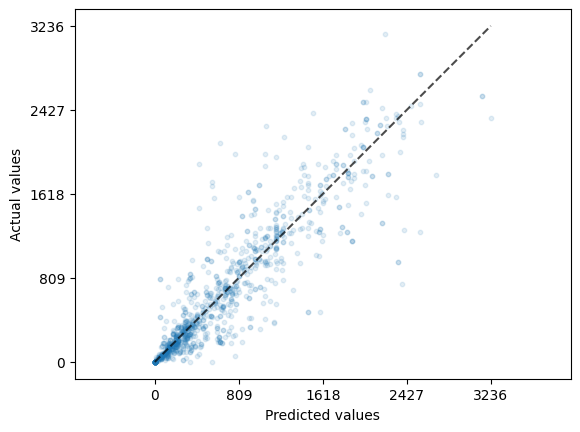

In [26]:
# Plotting scatter plot for predicted value vs actual value on test set
PredictionErrorDisplay.from_estimator(
    tree_search,
    X_test,
    y_test,
    kind='actual_vs_predicted',
    scatter_kwargs={'alpha': 0.12, 's': 10}
)

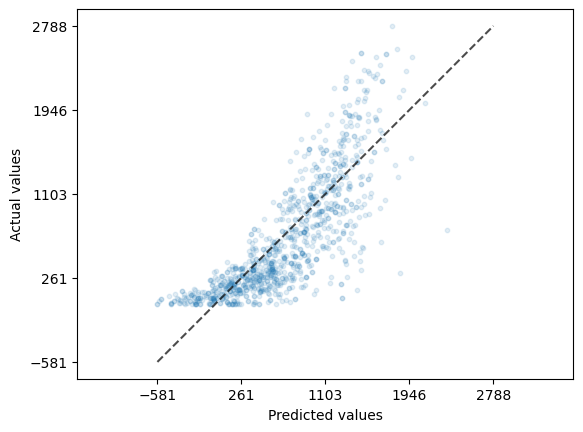

In [27]:
PredictionErrorDisplay.from_estimator(
    ridge_search,
    X_test,
    y_test,
    kind='actual_vs_predicted',
    scatter_kwargs={'alpha': 0.12, 's': 10}
)

Figure 7. Predicted bike usage by regression model vs actual bike usage from test data set.

The decision tree regression model did moderately well on the test data, with an $R^2$ of 0.79. Compared to the ridge regression model, it only obtained a $R^2$ of 0.68. This can also be seen by the scatter plot of the predicted bike usage versus the actual bike usage data. The ridge regression model has a wide spread of prediction for the entire range of bike usage, yet the decision tree regression model seems to be predicting the lower numbers well, albeit still struggling in predicting higher bike usage with the same precision. Despite this, since the bulk of the data lies within a lower range and this is the range where the model performs well, the model should still be able to provide a reasonably accurate predictions for most of the observations.

# Discussion

From the model results reflects the performance of two different models trained on the dataset: a Ridge Regression model and a Decision Tree Regressor. The Decision Tree model outperforms the Ridge Regression model in explaining the variance in the target variable (79.5% vs. 68.0%), this suggests that the data might have non-linear relationships that the Decision Tree is better able to capture compared to the linear Ridge Regression model.

While the Decision Tree achieves better performance, it might be more prone to overfitting if the hyperparameters (e.g., max_depth, min_samples_split, and min_samples_leaf) are not carefully tuned. The constraints imposed by the chosen hyperparameters reduce this risk. Ridge Regression, being a linear model, is less prone to overfitting but struggles to model complex, non-linear relationships.

The dataset includes both numerical and categorical variables (e.g., “Seasons,” “Holiday”), some of which may interact non-linearly with the target variable. This could explain the superior performance of the Decision Tree model. Features like “Temperature,” “Humidity,” and “Visibility” likely exhibit non-linear effects on the bike rental count, which Ridge Regression cannot model effectively.


The Decision Tree Regressor demonstrates better performance than Ridge Regression in terms of $R^2$ score, indicating that it better explained the variance in bike rentals, highlighting the importance of non-linear models for this dataset. However, proper interpretability, regularization, and validation are necessary to ensure the model’s robustness. The dataset’s complexity suggests that exploring more advanced ensemble methods could yield even better results.

# References

Dua, D. and Graff, C. (2017) UCI Machine Learning Repository. University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.

Eren, E. and Uz, V.E. (2020) A review on bike-sharing: The factors affecting bike-sharing demand. Sustainable Cities and Society 54:101882.

Harris, C.R. et al. (2020) Array programming with NumPy. Nature, 585:357–362.

Kruchten, N., Mease, J., and Moritz, D. (2022) VegaFusion: Automatic Server-Side Scaling for Interactive Vega Visualizations. IEEE Visualization and Visual Analytics (VIS), 2022: 11-15. doi: 10.1109/VIS54862.2022.00011.

McKinney, W. (2010) Data Structures for Statistical Computing in Python. In Proceedings of the 9th Python in Science Conference, edited by Stéfan van der Walt and Jarrod Millman, 51–56.

Pedregosa, F. et al. (2011) Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct):2825–2830.

Sathishkumar V.E., Park, J., and Cho, Y. (2020) Using data mining techniques for bike sharing demand prediction in Metropolitan city. Computer Communications, 153:353-366.

Sathishkumar V.E. and Cho, Y. (2020) A rule-based model for Seoul Bike sharing demand prediction using Weather data. European Journal of Remote Sensing, 52(1):166-183.

Shaheen, S.A., Guzman, S., and Zhang, H. (2010). Bikesharing in Europe, the Americas, and Asia: Past, Present, and Future. Transportation Research Record, 2143(1):159-167. https://doi.org/10.3141/2143-20 

VanderPlas, J. et al. (2018) Altair: Interactive statistical visualizations for python. Journal of open source software, 3(32):1057.

Van Rossum, G. and Drake, F.L. (2009) Python 3 Reference Manual. CreateSpace, Scotts Valley, CA.
